# ATP Tennis Data - Feature Engineering

In previous notebook, we pre-processed the ATP match data by:
* dropping columns with little data
* cleaning string columns
* imputing any data that we can reasonably impute

For this notebook, we will use the data saved from pre-processing and start doing some basic feature engineering so we can feed  our data to our models to see how we do. My goal is to start training models and see how they do as soon as possible, so we will stick with the following basic feature engineering techniques:
* one hot encode any categorical data - ie, tournament surface, round, winner_ioc, loser_ioc
* extra month from the tournament date
* label each row with 0 as Player 1 losing to Player 2 and 1 as Player 1 beats Player 2
* remove any remaining columns that we

Output of basic feature engineering:
* tournament
    * tournament id - extract from current tourney_id field
    * tournament level - encode
    * month of tournament - extract from tourney_date
    * year of tournament - extract from tourney_date
    * surface - one hot encode
    * draw size
    * best of
* player 1 and player 2
    * player id
    * rank
    * height
    * ioc - encode
    * age
    * seed
    * hand - encode
* match
    * round - encode
* label
    * whether player 1 beat player 2 - 0 - False, 1 - True
    

## Future:
In a future notebook, I plan on implementing more advanced feature engineering with:
* look up matchup history for players
    * match-up stats for pervious matchups
* add match player record leading up to the match for each player (ie, last X matches)
* look up player stats leading up to match for each player (ie, last X matches)
* contruct 2 entries of data per row since match-up and player record leading up to a match will differe depending on which player is player 1 or 2


## Missing Data:

There are some features that are  missing from our dataset. In the future, we could look into somehow scrapping or manually getting these. I looked at the ATP website to see how to get this data, but it is not readily apparent since each player/tournament has some type of unique identifier on their website that I haven't figure out how to get. Here are some potential features to get i the future:


* tournament
    * tournament location - ie, city, country
    * prize money
* player
    * weight
    * backhand - one/two handed
    * number of years as a pro

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json

%matplotlib inline
sns.set()

In [2]:
# Contants
START_YEAR = 1985
END_YEAR = 2019

DATASET_DIR = '../datasets'
MODEL_DIR = '../models'
# this is the file we generated from our pre-processing notebook
PREPROCESSED_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_preprocessed.csv'
FEATURE_FILE = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features.csv'
FEATURE_FILE_DIFF = f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff.csv'

pre = pd.read_csv(PREPROCESSED_FILE, parse_dates=["tourney_date"])
# pre = pre.astype({'draw_size': np.int32})


In [3]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 45 columns):
tourney_id       99955 non-null object
tourney_name     99955 non-null object
surface          99955 non-null object
draw_size        99955 non-null float64
tourney_level    99955 non-null object
tourney_date     99955 non-null datetime64[ns]
match_num        99955 non-null int64
winner_id        99955 non-null int64
winner_seed      99955 non-null float64
winner_name      99955 non-null object
winner_hand      99955 non-null object
winner_ht        99955 non-null float64
winner_ioc       99955 non-null object
winner_age       99955 non-null float64
loser_id         99955 non-null int64
loser_seed       99955 non-null float64
loser_name       99955 non-null object
loser_hand       99955 non-null object
loser_ht         99955 non-null float64
loser_ioc        99955 non-null object
loser_age        99955 non-null float64
score            99951 non-null object
best_of          9995

## Let's look at the data to make sure all the types are correct before we being

In [4]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 45 columns):
tourney_id       99955 non-null object
tourney_name     99955 non-null object
surface          99955 non-null object
draw_size        99955 non-null float64
tourney_level    99955 non-null object
tourney_date     99955 non-null datetime64[ns]
match_num        99955 non-null int64
winner_id        99955 non-null int64
winner_seed      99955 non-null float64
winner_name      99955 non-null object
winner_hand      99955 non-null object
winner_ht        99955 non-null float64
winner_ioc       99955 non-null object
winner_age       99955 non-null float64
loser_id         99955 non-null int64
loser_seed       99955 non-null float64
loser_name       99955 non-null object
loser_hand       99955 non-null object
loser_ht         99955 non-null float64
loser_ioc        99955 non-null object
loser_age        99955 non-null float64
score            99951 non-null object
best_of          9995

In [5]:
pre.sample(10).T

,44028,46830,38391,91821,28484,50025,23073,80183,15009,57599
tourney_id,1999-338,1999-352,1997-329,2015-352,1994-520,2001-891,1992-352,2011-540,1990-418,2003-317
tourney_name,sydney,paris masters,tokyo,paris masters,roland garros,chennai,paris masters,wimbledon,washington,amersfoort
surface,hard,carpet,hard,hard,clay,hard,carpet,grass,hard,clay
draw_size,32,64,64,64,128,32,64,128,64,32
tourney_level,a,m,a,m,g,a,m,g,a,a
tourney_date,1999-01-11 00:00:00,1999-11-01 00:00:00,1997-04-14 00:00:00,2015-11-02 00:00:00,1994-05-23 00:00:00,2001-01-01 00:00:00,1992-11-02 00:00:00,2011-06-20 00:00:00,1990-07-16 00:00:00,2003-07-14 00:00:00
match_num,13,30,29,44,71,27,25,93,27,11
winner_id,101774,102021,101889,104918,102035,103990,101589,104229,101190,102615
winner_seed,8,45,4,2,96,23,26,54,14,26
winner_name,todd martin,michael chang,todd woodbridge,andy murray,jonas bjorkman,tommy robredo,arnaud boetsch,yen hsun lu,darren cahill,dennis van scheppingen


# Tournament Info

* tournament id - extract from current tourney_id field
* tournament level - one hot encode
* month of tournament - extract from tourney_date
* year of tournament - extract from tourney_date
* surface - one hot encode
* draw size
* best of


### Extract tournment ID aand Encode

Since players may have an affinity for certainly tournaments because of location or conditions, we should include this into our features

First let's rename the columns since it's rather confusing - currently, tourney_id is a composite of {year}-{id}. ID is alphanumeric so we need to encode these

In [6]:
matches = pre
matches = matches.rename({"tourney_id": "tourney_year_plus_id"}, axis=1)
matches["tourney_id"] = matches.tourney_year_plus_id.apply(lambda x: x.split("-")[1])
matches.sample(5, random_state=1).tourney_id

57294    311
20858    434
17975    440
21211    520
89342    301
Name: tourney_id, dtype: object

In [7]:


tidle = LabelEncoder()
tid_labels = tidle.fit_transform(matches['tourney_id'])
tid_map = {label: num for num, label in enumerate(tidle.classes_)}
print(tid_map)

matches["tourney_id_label"] = matches["tourney_id"].map(tid_map)

# save off map to be used later
with open(f'{MODEL_DIR}/tid_map.json', 'w') as file:
    json.dump(tid_map, file)
    
matches.sample(10)[["tourney_id", "tourney_id_label"]]

{'0301': 0, '0308': 1, '0311': 2, '0314': 3, '0315': 4, '0316': 5, '0319': 6, '0321': 7, '0322': 8, '0328': 9, '0329': 10, '0337': 11, '0341': 12, '0352': 13, '0360': 14, '0375': 15, '0402': 16, '0407': 17, '0410': 18, '0414': 19, '0421': 20, '0424': 21, '0425': 22, '0429': 23, '0439': 24, '0451': 25, '0495': 26, '0496': 27, '0499': 28, '0500': 29, '0506': 30, '0533': 31, '0568': 32, '0605': 33, '0717': 34, '0741': 35, '0773': 36, '0891': 37, '1536': 38, '1720': 39, '201': 40, '215': 41, '224': 42, '2276': 43, '237': 44, '240': 45, '301': 46, '302': 47, '303': 48, '304': 49, '305': 50, '306': 51, '308': 52, '309': 53, '310': 54, '311': 55, '312': 56, '313': 57, '314': 58, '315': 59, '316': 60, '317': 61, '318': 62, '319': 63, '321': 64, '322': 65, '323': 66, '325': 67, '326': 68, '327': 69, '328': 70, '329': 71, '330': 72, '332': 73, '3348': 74, '336': 75, '337': 76, '338': 77, '339': 78, '341': 79, '3465': 80, '348': 81, '352': 82, '354': 83, '357': 84, '359': 85, '360': 86, '366': 87

,tourney_id,tourney_id_label
32323,540,153
34039,338,77
18915,560,155
17228,329,71
40460,357,84
19597,430,119
47306,402,92
9856,580,158
70247,375,89
14609,311,55


### Tournament Level

Tournament level does have some type of implicit ordinality to them since tournaments are worth different points according to their levels with 'g' (grand slams) worth the most number of points

We will do a custom encoding for these

Here are the point values for winner the levels:
* g - grand slam - 2000
* f - tour final - 1500
* m - masters - 1000
* a - other tour event - anywhere between 250 to 500 depending on the series

In [8]:
np.unique(matches.tourney_level)

array(['a', 'f', 'g', 'm'], dtype=object)

In [9]:
import json

level_map = {'g': 1, 'f': 2, 'm': 3, 'a': 4}
matches["tourney_level_label"] = matches['tourney_level'].map(level_map)
# let's check our work
matches.sample(10)[["tourney_level", "tourney_level_label"]]

# let's save off the map for later use
with open(f'{MODEL_DIR}/tourney_level_map.json', 'w') as file:
    json.dump(level_map, file)

### Tournamant year and Month

We can extract this from the tourney_date

In [10]:
matches["tourney_year"] = matches.tourney_date.dt.year
matches["tourney_month"] = matches.tourney_date.dt.month
matches.sample(10)[["tourney_year", "tourney_month", "tourney_date"]]

,tourney_year,tourney_month,tourney_date
88715,2014,8,2014-08-25
19661,1991,11,1991-11-04
80937,2011,10,2011-10-03
99534,2018,10,2018-10-01
70634,2008,1,2008-01-28
84336,2013,2,2013-02-11
79703,2011,5,2011-05-01
54754,2002,7,2002-07-15
93722,2016,7,2016-07-25
33857,1995,11,1995-11-06


### Tournament Surface

There is no ordinality here so we can just use a label encoder

In [11]:

surface_le = LabelEncoder()
surface_labels = surface_le.fit_transform(matches['surface'])
surface_map = {label: num for num, label in enumerate(surface_le.classes_)}
print(surface_map)

matches["surface_label"] = matches["surface"].map(surface_map)

# save off map to be used later
with open(f'{MODEL_DIR}/surface_map.json', 'w') as file:
    json.dump(surface_map, file)
    
matches.sample(10)[["surface", "surface_label"]]

{'carpet': 0, 'clay': 1, 'grass': 2, 'hard': 3}


,surface,surface_label
372,carpet,0
72672,hard,3
72075,clay,1
17391,hard,3
93093,clay,1
49329,hard,3
75341,hard,3
72024,grass,2
62062,clay,1
87520,clay,1


# Generate Player Features

Most are already numbers that we can feed into the model - we will just keep these for now

### Player origin (ioc)

Again there is no ordinality to this so we will use the LabelEncoder

In [12]:
ioc_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
ioc_labels = ioc_le.fit_transform(matches["loser_ioc"].append(matches["winner_ioc"]))
ioc_map = {label: num for num, label in enumerate(ioc_le.classes_)}
print(ioc_map)

matches["loser_ioc_label"] = matches["loser_ioc"].map(ioc_map)
matches["winner_ioc_label"] = matches["winner_ioc"].map(ioc_map)

# save off map to be used later
with open(f'{MODEL_DIR}/ioc_map.json', 'w') as file:
    json.dump(ioc_map, file)
    
matches.sample(10)[["loser_ioc", "loser_ioc_label", "winner_ioc", "winner_ioc_label"]]

{'alg': 0, 'arg': 1, 'arm': 2, 'aus': 3, 'aut': 4, 'aze': 5, 'bah': 6, 'bar': 7, 'bel': 8, 'ben': 9, 'ber': 10, 'bih': 11, 'blr': 12, 'bol': 13, 'bra': 14, 'bul': 15, 'can': 16, 'chi': 17, 'chn': 18, 'civ': 19, 'col': 20, 'crc': 21, 'cro': 22, 'cub': 23, 'cyp': 24, 'cze': 25, 'den': 26, 'dom': 27, 'ecu': 28, 'egy': 29, 'esa': 30, 'esp': 31, 'est': 32, 'fin': 33, 'fra': 34, 'gbr': 35, 'geo': 36, 'ger': 37, 'gre': 38, 'hai': 39, 'hkg': 40, 'hun': 41, 'ina': 42, 'ind': 43, 'iri': 44, 'irl': 45, 'isr': 46, 'ita': 47, 'jam': 48, 'jpn': 49, 'kaz': 50, 'ken': 51, 'kor': 52, 'kuw': 53, 'lat': 54, 'ltu': 55, 'lux': 56, 'mar': 57, 'mas': 58, 'mda': 59, 'mex': 60, 'mkd': 61, 'mon': 62, 'ned': 63, 'ngr': 64, 'nor': 65, 'nzl': 66, 'pak': 67, 'par': 68, 'per': 69, 'phi': 70, 'pol': 71, 'por': 72, 'pur': 73, 'qat': 74, 'rou': 75, 'rsa': 76, 'rus': 77, 'sen': 78, 'slo': 79, 'srb': 80, 'sui': 81, 'svk': 82, 'swe': 83, 'tha': 84, 'tog': 85, 'tpe': 86, 'tun': 87, 'tur': 88, 'uae': 89, 'ukr': 90, 'unk': 9

,loser_ioc,loser_ioc_label,winner_ioc,winner_ioc_label
88546,pol,71,can,16
56042,usa,93,rus,77
30625,fra,34,swe,83
88715,col,20,rus,77
89978,esp,31,esp,31
42429,nzl,66,ned,63
79873,rus,77,esp,31
75704,esp,31,fra,34
46410,mar,57,swe,83
40048,crc,21,esp,31


### Player Hand - (l/r/u)

This is simple categorial data - will use LabelEncoder

In [13]:
hand_le = LabelEncoder()
# we have to append loser and winner list to get comprehensive list
hand_labels = hand_le.fit_transform(matches["loser_hand"].append(matches["winner_hand"]))
hand_map = {label: num for num, label in enumerate(hand_le.classes_)}
print(hand_map)

matches["loser_hand_label"] = matches["loser_hand"].map(hand_map)
matches["winner_hand_label"] = matches["winner_hand"].map(hand_map)

# save off map to be used later
with open(f'{MODEL_DIR}/hand_map.json', 'w') as file:
    json.dump(hand_map, file)
    
matches.sample(10)[["loser_hand", "loser_hand_label", "winner_hand", "winner_hand_label"]]

{'l': 0, 'r': 1, 'u': 2}


,loser_hand,loser_hand_label,winner_hand,winner_hand_label
76776,r,1,l,0
28454,r,1,r,1
31857,r,1,r,1
96824,r,1,r,1
62244,r,1,r,1
13904,r,1,r,1
56947,r,1,r,1
56196,r,1,r,1
31589,l,0,r,1
25420,r,1,r,1


## Match Features

Only feature we will use for now is round. There is an ordinality to the rounds so we will use a custome encoding

Couple issues with this:

'rr' - means round robin. This usually means that all players in a tournament is divided into multiple flights (ie, 2). All players in the flight play against each other. The year end final for instance has 8 players. Top 2 players from each flight make it to semi finals. Winner of that match goes to finals. So rr could mean any of the 3 matches a player would play in the flight. We will just pick the next unique number to encode this.

https://en.wikipedia.org/wiki/ATP_Finals

'br' - Not sure what this indicates. Will encode this as the last value

<red>try one hot encoding and see the effect</red>

In [14]:
np.unique(matches["round"])

array(['br', 'f', 'qf', 'r128', 'r16', 'r32', 'r64', 'rr', 'sf'],
      dtype=object)

In [15]:
round_map = {'f': 1, 
            'sf': 2,
            'qf': 3,
            'r16': 4,
            'r32': 5,
            'r64': 6,
            'r128': 7,
            'rr': 8,
            'br': 9}
matches["round_label"] = matches["round"].map(round_map)

# save off map to be used later
with open(f'{MODEL_DIR}/round_map.json', 'w') as file:
    json.dump(round_map, file)
    
matches.sample(10)[["round", "round_label"]]


,round,round_label
98779,r64,6
9492,qf,3
98243,r64,6
21477,f,1
16426,r32,5
72816,r32,5
3953,r32,5
3840,r64,6
8685,r128,7
94376,sf,2


# Let's check out our data one more time

In [16]:
matches.sample(10).T

,69040,72937,3262,98321,19144,67295,76733,30536,95405,14048
tourney_year_plus_id,2007-741,2008-1536,1987-401,2018-m009,1991-325,2006-337,2010-360,1995-301,2017-0410,1990-410
tourney_name,nottingham,madrid masters,philadelphia,rome masters,palermo,vienna,casablanca,auckland,monte carlo masters,monte carlo masters
surface,grass,hard,carpet,clay,clay,hard,clay,hard,clay,clay
draw_size,32,64,64,64,32,32,32,32,64,64
tourney_level,a,m,a,m,a,a,a,a,m,m
tourney_date,2007-06-18 00:00:00,2008-10-12 00:00:00,1987-02-02 00:00:00,2018-05-14 00:00:00,1991-09-23 00:00:00,2006-10-09 00:00:00,2010-04-05 00:00:00,1995-01-09 00:00:00,2017-04-17 00:00:00,1990-04-23 00:00:00
match_num,5,8,12,281,18,5,24,31,266,24
winner_id,102035,104068,100714,105453,101404,104571,103722,102358,105077,101611
winner_seed,4,44,26,20,8,4,8,9,15,54
winner_name,jonas bjorkman,robby ginepri,broderick dyke,kei nishikori,thomas muster,marcos baghdatis,florent serra,thomas enqvist,albert ramos,cedric pioline


# 1 - Generate Features and Ground Truth

This is going to be a little bit tricky. If we leave the columns as it, all of our labels for winner/loser would be 1 since winner column is first.

Instead, we are going to have to loop through all rows and randomly place winner or loser as player 1 so that we can have labels that are both 0 and 1

In [17]:
import random

tourney_cols = ["tourney_id_label", "tourney_level_label", "tourney_year", "tourney_month", "surface_label", "draw_size", "round_label"]

def generate_feature_row(row: pd.Series, p1winner: bool) -> dict:
    m = {}
    # first add static columns for tournament and match
    for tc in tourney_cols:
        m[tc] = row[tc]
        
    # now depending on what random gives us either put winner as p1 or loser as p1
    m1 = {}
    if p1winner:
        m1 = {
            "p1": row.winner_id,
            "p1_rank": row.winner_rank,
            "p1_ht": row.winner_ht,
            "p1_ioc": row.winner_ioc_label,
            "p1_age": row.winner_age,
            "p1_seed": row.winner_seed,
            "p1_hand": row.winner_hand_label,
            "p2": row.loser_id,
            "p2_rank": row.loser_rank,
            "p2_ht": row.loser_ht,
            "p2_ioc": row.loser_ioc_label,
            "p2_age": row.loser_age,
            "p2_seed": row.loser_seed,
            "p2_hand": row.loser_hand_label,
            "p1_winner": 1
        }
    else:
        m1 = {
            "p1": row.loser_id,
            "p1_rank": row.loser_rank,
            "p1_ht": row.loser_ht,
            "p1_ioc": row.loser_ioc_label,
            "p1_age": row.loser_age,
            "p1_seed": row.loser_seed,
            "p1_hand": row.loser_hand_label,
            "p2": row.winner_id,
            "p2_rank": row.winner_rank,
            "p2_ht": row.winner_ht,
            "p2_ioc": row.winner_ioc_label,
            "p2_age": row.winner_age,
            "p2_seed": row.winner_seed,
            "p2_hand": row.winner_hand_label,
            "p1_winner": 0
        }
    m.update(m1)
    return m

features = pd.DataFrame()
for _, row in matches.iterrows():
    d = generate_feature_row(row, round(random.uniform(0,1)) == 0)
    features = features.append(d, ignore_index=True)
    


In [18]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 22 columns):
draw_size              99955 non-null float64
p1                     99955 non-null float64
p1_age                 99955 non-null float64
p1_hand                99955 non-null float64
p1_ht                  99955 non-null float64
p1_ioc                 99955 non-null float64
p1_rank                99955 non-null float64
p1_seed                99955 non-null float64
p1_winner              99955 non-null float64
p2                     99955 non-null float64
p2_age                 99955 non-null float64
p2_hand                99955 non-null float64
p2_ht                  99955 non-null float64
p2_ioc                 99955 non-null float64
p2_rank                99955 non-null float64
p2_seed                99955 non-null float64
round_label            99955 non-null float64
surface_label          99955 non-null float64
tourney_id_label       99955 non-null float64
tourney_level_lab

In [19]:
type_map = {
    "tourney_id_label": np.int32,
    "tourney_level_label": np.int32,
    "tourney_year": np.int32,
    "tourney_month": np.int32,
    "surface_label": np.int32,
    "draw_size": np.int32,
    "round_label": np.int32,
    "p1": np.int32,
    "p1_rank": np.int32,
    "p1_ioc": np.int32,
    "p1_seed": np.int32,
    "p1_hand": np.int32,
    "p2": np.int32,
    "p2_rank": np.int32,
    "p2_ioc": np.int32,
    "p2_seed": np.int32,
    "p2_hand": np.int32,
    "p1_winner": np.int32    
}

features = features.astype(type_map)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 22 columns):
draw_size              99955 non-null int32
p1                     99955 non-null int32
p1_age                 99955 non-null float64
p1_hand                99955 non-null int32
p1_ht                  99955 non-null float64
p1_ioc                 99955 non-null int32
p1_rank                99955 non-null int32
p1_seed                99955 non-null int32
p1_winner              99955 non-null int32
p2                     99955 non-null int32
p2_age                 99955 non-null float64
p2_hand                99955 non-null int32
p2_ht                  99955 non-null float64
p2_ioc                 99955 non-null int32
p2_rank                99955 non-null int32
p2_seed                99955 non-null int32
round_label            99955 non-null int32
surface_label          99955 non-null int32
tourney_id_label       99955 non-null int32
tourney_level_label    99955 non-null int32
tou

In [20]:
features.sample(10).T

,56854,45930,91594,77709,43370,53610,68451,98501,12687,94582
draw_size,32.00,32.00,64.00,32.00,16.00,64.00,64.00,128.00,32.00,32.000000
p1,102107.00,102839.00,105683.00,105208.00,102344.00,102562.00,103900.00,104925.00,100946.00,104534.000000
p1_age,30.66,22.97,24.79,21.90,24.57,26.97,25.28,31.02,26.24,31.750000
p1_hand,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.000000
p1_ht,190.00,188.00,196.00,190.00,188.00,190.00,180.00,188.00,198.00,175.000000
p1_ioc,65.00,28.00,16.00,54.00,82.00,25.00,1.00,80.00,97.00,46.000000
p1_rank,337.00,21.00,9.00,28.00,6.00,15.00,12.00,22.00,78.00,96.000000
p1_seed,32.00,2.00,9.00,5.00,3.00,13.00,9.00,20.00,19.00,17.000000
p1_winner,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.000000
p2,104022.00,101675.00,105064.00,105041.00,102271.00,103694.00,103487.00,105138.00,101381.00,106421.000000


### Save to File

In [21]:
features.to_csv(FEATURE_FILE, index=False)

### Check that we are roughly evenly distributed since we used the uniform distribution

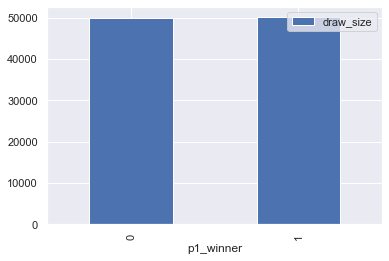

In [22]:
features[['p1_winner','draw_size']].groupby("p1_winner").count().plot(kind='bar')

# 2- Generate Features and Ground Truth (Diff Stats)

We are going to generate the features a little bit differently here. We have p1 and p2 stats, what if we diffed the stats instead of putting both into our dataset?

This would reduce the number of features we have. For our data, it probably doesn't matter, but for a dataset that has more columns, this could be a way to save on memory and training time.


In [23]:
import random

tourney_cols = ["tourney_id_label", "tourney_level_label", "tourney_year", "tourney_month", "surface_label", "draw_size", "round_label"]

def generate_feature_row(row: pd.Series, p1winner: bool) -> dict:
    m = {}
    # first add static columns for tournament and match
    for tc in tourney_cols:
        m[tc] = row[tc]
        
    # now depending on what random gives us either put winner as p1 or loser as p1
    m1 = {}
    if p1winner:
        m1 = {
            "p1": row.winner_id,
            "rank_diff": row.winner_rank - row.loser_rank,
            "ht_diff": row.winner_ht - row.loser_ht,
            "p1_ioc": row.winner_ioc_label,
            "age_diff": row.winner_age - row.loser_age,
            "seed_diff": row.winner_seed - row.loser_age,
            "p1_hand": row.winner_hand_label,
            "p2": row.loser_id,
            "p2_ioc": row.loser_ioc_label,
            "p2_hand": row.loser_hand_label,
            "p1_winner": 1
        }
    else:
        m1 = {
            "p1": row.loser_id,
            "rank_diff": row.loser_rank - row.winner_rank,
            "ht_diff": row.loser_ht - row.winner_ht,
            "p1_ioc": row.loser_ioc_label,
            "age_diff": row.loser_age - row.winner_age,
            "seed_diff": row.loser_seed - row.winner_seed,
            "p1_hand": row.loser_hand_label,
            "p2": row.winner_id,
            "p2_ioc": row.winner_ioc_label,
            "p2_hand": row.winner_hand_label,
            "p1_winner": 0
        }
    m.update(m1)
    return m

features_diff = pd.DataFrame()
for _, row in matches.iterrows():
    d = generate_feature_row(row, round(random.uniform(0,1)) == 0)
    features_diff = features_diff.append(d, ignore_index=True)

# looks like creating a DF with this method, it sets all numeric columns to float
# we want to set the types back to int so we don't get extra .0 at the end of the column names
features_diff = features_diff.astype({"draw_size": np.int32, 
                                     "p1": np.int32,
                                    "p1_hand": np.int32, 
                                     "p1_ioc": np.int32,
                                    "p1_winner": np.int32, 
                                     "p2": np.int32,
                                    "p2_hand": np.int32, 
                                     "p2_ioc": np.int32,
                                     "rank_diff": np.int32,
                                    "round_label": np.int32,
                                    "surface_label": np.int32,
                                    "tourney_id_label": np.int32,
                                    "tourney_level_label": np.int32,
                                    "tourney_month": np.int32,
                                    "tourney_year": np.int32})

features_diff.to_csv(FEATURE_FILE_DIFF, index=False)

In [39]:
features_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 18 columns):
age_diff               99955 non-null float64
draw_size              99955 non-null int32
ht_diff                99955 non-null float64
p1                     99955 non-null int32
p1_hand                99955 non-null int32
p1_ioc                 99955 non-null int32
p1_winner              99955 non-null int32
p2                     99955 non-null int32
p2_hand                99955 non-null int32
p2_ioc                 99955 non-null int32
rank_diff              99955 non-null int32
round_label            99955 non-null int32
seed_diff              99955 non-null float64
surface_label          99955 non-null int32
tourney_id_label       99955 non-null int32
tourney_level_label    99955 non-null int32
tourney_month          99955 non-null int32
tourney_year           99955 non-null int32
dtypes: float64(3), int32(15)
memory usage: 8.0 MB


In [42]:
features_diff.head()

,age_diff,draw_size,ht_diff,p1,p1_hand,p1_ioc,p1_winner,p2,p2_hand,p2_ioc,rank_diff,round_label,seed_diff,surface_label,tourney_id_label,tourney_level_label,tourney_month,tourney_year
0,0.741947,32,-5.0,100617,1,93,1,108265,1,66,-226,5,-24.638053,3,46,4,1,1986
1,1.210000,32,10.0,100587,1,66,1,100680,0,3,-102,5,0.400000,3,46,4,1,1986
2,-1.370000,32,3.0,100868,1,3,1,100751,1,1,88,5,-8.590000,3,46,4,1,1986
3,12.920000,32,10.0,100326,1,66,1,101325,1,35,-317,5,-10.950000,3,46,4,1,1986
4,-0.150000,32,-18.0,100772,1,66,1,100761,1,93,-186,5,-21.440000,3,46,4,1,1986


# 3 - Generate Features and Ground Truth Using One Hot Encoding

For our categorical data, we are currently using label encoding. Label encoding basically assigned a unique number to each categorical value and we use this as features

Alternative method is to use one hot encoding. Each category will be coverted into a unique column - 1 will be assigned to the column if the value matches that column, all other columns will have 0 value. We will try this method to see if it makes a difference in our models

Our categories are:
* player id
* player hand
* player ioc (origin)
* tournament ID
* surface

In [25]:
from sklearn.preprocessing import OneHotEncoder
import pickle

# def encode_columns(df: pd.DataFrame, col1: str, col2: str = None, col_labels: list = None) -> (pd.DataFrame, OneHotEncoder):
def ohe_columns(name: str, df: pd.DataFrame, col1: str, col2: str = None) -> (pd.DataFrame, OneHotEncoder):
    """
    Encodes columns and returns a DataFrame and encoder
    :param: name - encoder name to save
    :param: df - dataframe with data
    :param: col1 - name of first column to encode (ie, p1 column)
    :param: col2 - name of 2nd column to encode (ie, p2 column) - we need to do this so that the encoder knows about all values for p1 and p2
    
    :return: dataframe with encoded values and column names
    :return: encoder
    """
    encoded_return = None
    ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, dtype=np.int)
    if col2:
        # sometimes not all values are in one column between p1 and p2, we have to melt them to fit the encoder
        ohe.fit(pd.melt(df[[col1, col2]])[["value"]])
        encoded_array1 = ohe.transform(df[[col1]])
        encoded_array2 = ohe.transform(df[[col2]])
        encoded_df = pd.DataFrame(encoded_array1, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_df2 = pd.DataFrame(encoded_array2, columns=[col2 + "_" + str(col) for col in ohe.categories_[-1]])
        encoded_pd = pd.concat([encoded_df, encoded_df2], axis=1)
    else:
        encoded_array = ohe.fit_transform(df[[col1]])
        encoded_pd = pd.DataFrame(encoded_array, columns=[col1 + "_" + str(col) for col in ohe.categories_[-1]])

    # save off our encoder
    pickle.dump(ohe, open(f'{MODEL_DIR}/{name}_ohe.pkl', 'wb'))
    
    # drop old columns
    return_pd = pd.concat([df, encoded_pd], axis=1)
    if col2:
        return_pd = return_pd.drop([col1, col2], axis=1)
    else:
        return_pd = return_pd.drop([col1], axis=1)
    
    
    return return_pd, ohe



### let's recreate the diff dataset but we will not use encoded columns

ohe the following columns: 
player id
player hand
player ioc (origin)
tournament ID
surface

In [26]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 22 columns):
draw_size              99955 non-null int32
p1                     99955 non-null int32
p1_age                 99955 non-null float64
p1_hand                99955 non-null int32
p1_ht                  99955 non-null float64
p1_ioc                 99955 non-null int32
p1_rank                99955 non-null int32
p1_seed                99955 non-null int32
p1_winner              99955 non-null int32
p2                     99955 non-null int32
p2_age                 99955 non-null float64
p2_hand                99955 non-null int32
p2_ht                  99955 non-null float64
p2_ioc                 99955 non-null int32
p2_rank                99955 non-null int32
p2_seed                99955 non-null int32
round_label            99955 non-null int32
surface_label          99955 non-null int32
tourney_id_label       99955 non-null int32
tourney_level_label    99955 non-null int32
tou

In [27]:
def get_reverse_map(encoder: LabelEncoder) -> dict:
    """
    reverses label encoder mapping into a dictionary so we can map values back into original values
    :param: encoder - label encoder
    :return: dict with reverse mapping from label encoder
    """
    return {i: encoder.classes_[i] for i in range(0, len(encoder.classes_))}
    

To save time, instead of iterating and recreating the data set, we are going to reverse encode columns that we encoded using label encoder

Then we will use our ohe function to one hot encode these columns into more feature columns

In [43]:
# let's make a copy of our data
features_ohe = features_diff.copy()

# reverse player hand
hand_reverse_map = get_reverse_map(hand_le)
features_ohe["p1_hand"] = features_ohe["p1_hand"].map(hand_reverse_map)
features_ohe["p2_hand"] = features_ohe["p2_hand"].map(hand_reverse_map)

# reverse player ioc
ioc_reverse_map = get_reverse_map(ioc_le)
features_ohe["p1_ioc"] = features_ohe["p1_ioc"].map(ioc_reverse_map)
features_ohe["p2_ioc"] = features_ohe["p2_ioc"].map(ioc_reverse_map)

# reverse surface
surface_reverse_map = get_reverse_map(surface_le)
features_ohe["surface_label"] = features_ohe["surface_label"].map(surface_reverse_map)


print(features_ohe[["p1_hand", "p2_hand", "p1_ioc", "p2_ioc", "surface_label", "p1", "p2", "tourney_id_label"]].head())

features_ohe.info()

  p1_hand p2_hand p1_ioc p2_ioc surface_label      p1      p2  \
0       r       r    usa    nzl          hard  100617  108265   
1       r       l    nzl    aus          hard  100587  100680   
2       r       r    aus    arg          hard  100868  100751   
3       r       r    nzl    gbr          hard  100326  101325   
4       r       r    nzl    usa          hard  100772  100761   

   tourney_id_label  
0                46  
1                46  
2                46  
3                46  
4                46  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Data columns (total 18 columns):
age_diff               99955 non-null float64
draw_size              99955 non-null int32
ht_diff                99955 non-null float64
p1                     99955 non-null int32
p1_hand                99955 non-null object
p1_ioc                 99955 non-null object
p1_winner              99955 non-null int32
p2                     99955 non-null int32
p2_hand   

In [44]:
features_ohe, hand_ohe = ohe_columns("hand", features_ohe, "p1_hand", "p2_hand")
features_ohe, surface_ohe = ohe_columns("surface", features_ohe, "surface_label")
features_ohe, ioc_ohe = ohe_columns("ioc", features_ohe, "p1_ioc", "p2_ioc")
features_ohe, tourney_id_ohe = ohe_columns("tourney_id", features_ohe, "tourney_id_label")
features_ohe, player_id_ohe = ohe_columns("player_id", features_ohe, "p1", "p2")

features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Columns: 5252 entries, age_diff to p2_205734
dtypes: float64(3), int32(7), int64(5242)
memory usage: 3.9 GB


In [45]:
features_ohe.head()

,age_diff,draw_size,ht_diff,p1_winner,rank_diff,round_label,seed_diff,tourney_level_label,tourney_month,tourney_year,...,p2_200611,p2_200615,p2_200624,p2_200630,p2_202090,p2_202130,p2_202358,p2_202359,p2_202385,p2_205734
0,0.741947,32,-5.0,1,-226,5,-24.638053,4,1,1986,...,0,0,0,0,0,0,0,0,0,0
1,1.210000,32,10.0,1,-102,5,0.400000,4,1,1986,...,0,0,0,0,0,0,0,0,0,0
2,-1.370000,32,3.0,1,88,5,-8.590000,4,1,1986,...,0,0,0,0,0,0,0,0,0,0
3,12.920000,32,10.0,1,-317,5,-10.950000,4,1,1986,...,0,0,0,0,0,0,0,0,0,0
4,-0.150000,32,-18.0,1,-186,5,-21.440000,4,1,1986,...,0,0,0,0,0,0,0,0,0,0


In [46]:
features_ohe.to_csv(f'{DATASET_DIR}/atp_matches_{START_YEAR}-{END_YEAR}_features-diff-ohe.csv', index=False)

In [47]:
features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99955 entries, 0 to 99954
Columns: 5252 entries, age_diff to p2_205734
dtypes: float64(3), int32(7), int64(5242)
memory usage: 3.9 GB


In [48]:
features_ohe.shape

(99955, 5252)